# Модель черного тела

Создать модель абсолютно черного тела и построить траекторию прохождения электромагнитного излучения через модель.

На выходе моделирования необходимо расcчитать сколько излучения поглощается, рассеивается.

Задать температуру черного тела и получить спектр черного тела у выходящего из отверстия электромагнитного излучения.

$R_\lambda = \frac{2\pi hc^2}{\lambda^5} \frac{1}{e^{{hc}/{\lambda k T}} - 1}$

In [765]:
from scipy.constants import h, c, k, micro, sigma
import numpy as np


def blackbody_radiation(l, t):
    a = 2 * np.pi * h * c ** 2
    b = h * c / (l * k * t)
    return a / ((l ** 5) * (np.exp(b) - 1))

In [766]:
import matplotlib.pyplot as plt


def analyze():
    temperatures = np.linspace(1e3, 12e3, 6)
    lambdas = np.linspace(0.05, 1, 10000) * micro
    for t in temperatures:
        plt.plot(lambdas, blackbody_radiation(lambdas, t))
        plt.xlabel('$\lambda$')
        plt.ylabel('$R(\lambda, T)$')

In [767]:
import math


class Trajectory:
    # ax + by + c = 0
    # x^2 + y^2 = r^2
    eps = 1e-3

    def __init__(self, line_coef: tuple, r: float, hole_size=.5, black_body_coef=1):
        self.line_coef = line_coef
        self.r = r
        self.point = (0, 0)
        self.point = self.get_next_point()
        self.entry_point = self.point
        self.hole_size = min(4 * self.r, hole_size)
        self.black_body_coef = black_body_coef

    @staticmethod
    def line_coefficients(p0: tuple, p1: tuple):
        # (x - x1) / (x2 - x1) - (y - y1) / (y2 - y1) = 0
        x1, y1 = p0
        x2, y2 = p1
        return 1 / (x2 - x1), -1 / (y2 - y1), y1 / (y2 - y1) - x1 / (x2 - x1)

    @staticmethod
    def line_value(line_coef: tuple, x0: float):
        a, b, c = line_coef
        return -(a * x0 + c) / b

    def circle_value(self, x0: float):
        return -np.sqrt(self.r ** 2 - x0 ** 2), np.sqrt(self.r ** 2 - x0 ** 2)

    def solve_line_circle(self):
        a, b, c = self.line_coef
        s = (a ** 2 + b ** 2)
        x0 = -a * c / s
        y0 = -b * c / s
        if c ** 2 > self.r ** 2 * s + self.eps or np.abs(c ** 2 - self.r ** 2 * s) < self.eps:
            raise ValueError('line don\'t have 2 intersection points with circle')
        else:
            d = self.r ** 2 - c ** 2 / s
            mult = np.sqrt(d / s)
            return (x0 + b * mult, y0 - a * mult), (x0 - b * mult, y0 + a * mult)

    @staticmethod
    def solve_lines(line_coef1, line_coef2):
        a1, b1, c1 = line_coef1
        a2, b2, c2 = line_coef2
        x = (c2 * b1 - c1 * b2) / (a1 * b2 - a2 * b1)
        y = -a2 * x / b2 - c2 / b2
        return x, y

    @staticmethod
    def perpendicular_line_coef(line_coef: tuple, p0: tuple):
        a, b, c = line_coef
        x, y = p0
        return -b, a, b * x - a * y

    @staticmethod
    def distance_between(p0: tuple, p1: tuple):
        return math.dist(p0, p1)

    def get_closest(self, p0, pm, p2):
        return p0 if self.distance_between(p0, pm) < self.distance_between(p2, pm) else p2

    def get_next_point(self):
        p0, p1 = self.solve_line_circle()
        d0, d1 = self.distance_between(self.point, p0), self.distance_between(self.point, p1)
        return p0 if d0 > d1 else p1

    @staticmethod
    def get_symmetrical_point(p1: tuple, pm: tuple):
        x1, y1 = p1
        xm, ym = pm
        return 2 * xm - x1, 2 * ym - y1

    def is_exit(self, p0: tuple):
        x0, y0 = self.entry_point
        x, y = p0
        return (max(-self.r, x - self.hole_size / 2) <= x0 <= min(x + self.hole_size / 2, self.r) and
                max(-self.r, y - self.hole_size / 2) <= y0 <= min(y + self.hole_size / 2, self.r))

    def draw(self, niter=1):
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(self.point[0], self.point[1], c='black', s=15)
        while niter > 0:
            next_point = self.get_next_point()
            radius_line = self.line_coefficients((0, 0), next_point)
            perpendicular_line = self.perpendicular_line_coef(radius_line, (0, 0))
            intersection_point = self.solve_lines(perpendicular_line, self.line_coef)
            symmetrical_point = self.get_symmetrical_point(intersection_point, (0, 0))
            symmetrical_line = self.line_coefficients(next_point, symmetrical_point)
            points = np.linspace(self.point[0], next_point[0], 2)
            ax.plot(points, self.line_value(self.line_coef, points), c='red', alpha=.8, linewidth=.5)
            self.line_coef = symmetrical_line
            self.point = next_point
            if self.is_exit(next_point):
                break
            niter -= 1

        plt.gcf().gca().add_artist(plt.Circle((0, 0), self.r, fill=False))
        x_left, x_right = (max(-self.r, self.entry_point[0] - self.hole_size / 2),
                           min(self.r, self.entry_point[0] + self.hole_size / 2))
        ys_left, ys_right = self.circle_value(x_left), self.circle_value(x_right)
        closest_left = self.get_closest((x_left, ys_left[0]), self.entry_point, (x_left, ys_left[1]))
        closest_right = self.get_closest((x_right, ys_right[0]), self.entry_point, (x_right, ys_right[1]))
        plt.scatter(closest_left[0], closest_left[1], marker="|", c='blue')
        plt.scatter(closest_right[0], closest_right[1], marker="|", c='blue')
        ax.set_aspect('equal', adjustable='box')
        plt.xlim([-1.2 * self.r, 1.2 * self.r])
        plt.ylim([-1.2 * self.r, 1.2 * self.r])
        plt.axis('off')

    def info(self, temperature):
        k = (self.black_body_coef / (1 - self.black_body_coef) if self.black_body_coef != 1 else 0)
        energy_absorption = k * (self.hole_size / (np.pi * self.r))
        energy_dissipation = 1 - self.black_body_coef
        energy_luminosity = sigma * temperature ** 4
        print(f'Absorption: {energy_absorption}% \nDissipation: {energy_dissipation} \nLuminosity: {energy_luminosity} watt/m^2')

Absorption: 0.15915494309189537% 
Dissipation: 0.19999999999999996 
Luminosity: 459.300327939 watt/m^2


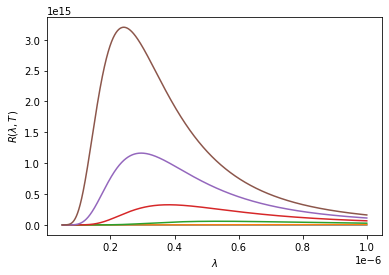

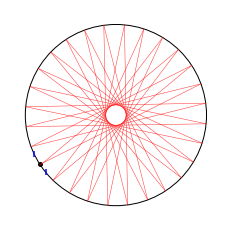

In [768]:
if __name__ == '__main__':
    trajectory = Trajectory((-1, 2, 2), 8, 1, black_body_coef=0.8)
    analyze()
    trajectory.draw(100)
    trajectory.info(300)